# One-Asset HANK Tutorial

The package supports heterogeneous agent models with and without porfolio chocie (i.e., with one asset and two assets, respectively). Start with some misc imports and load the package:

In [1]:
import jax.numpy as jnp # use jax.numpy instead of normal numpy
from grgrlib import figurator, grplot # a nice backend for batch plotting with matplotlib
import econpizza as ep # pizza
import matplotlib.pyplot as plt

# for nicer text in figures
plt.rc('text', usetex=True)
# only necessary if you run this in a jupyter notebook:
%matplotlib inline 

The provided example is the same model as [in the paper](https://gregorboehl.com/hank_speed_boehl.pdf), which is documented in the appendix. The [YAML file](https://github.com/gboehl/econpizza/blob/master/econpizza/examples/hank_with_comments.yml), with many comments, can be found in the examples folder.

Start with loading the example file:

In [2]:
example_hank = ep.examples.hank

As before, `example_hank` is nothing else than the path to the YAML file:

In [3]:
print(example_hank)

/home/gboehl/github/econpizza/econpizza/examples/hank_with_comments.yml


Parse the example hank model from the yaml and compile the model:

In [4]:
# parse model
hank1_dict = ep.parse(example_hank)
# compile the model
hank1 = ep.load(hank1_dict)

(load:) Parsing done.


The first step creates a raw dictionary from the yaml. The second translates everything to a model instance with compiled and tested functions. If something specific in your model does not work, you should have been informed by now.

Lets continue with the steady state:

In [5]:
stst_result = hank1.solve_stst()

    Iteration   1 | max. error 7.48e-01 | lapsed 5.2069
    Iteration   2 | max. error 7.56e-02 | lapsed 5.3326
    Iteration   3 | max. error 7.36e-04 | lapsed 5.3654
    Iteration   4 | max. error 7.06e-08 | lapsed 5.3978
(solve_stst:) Steady state found (5.6612s). The solution converged.


By default, the final message is rather verbose. The rank of the Jacobian is important because quite often, the steady state is indetermined and you need to fix some steady state values. Econpizza can deal with that by using the Pseudoinverse during the Newton steps. Fixing some of the variables is also what I did here. Since the function has 12 degrees of freedom and 6 fixed variables for a total of 18 variables, we're fine and the steady state solver nicely converges.

The resulting `stst_result` is similar to the return object from `scipy.optimize.root` and contains all sorts of nice information to help you debugging if you have problems finding the steady state:

In [6]:
print(stst_result.keys())

dict_keys(['success', 'message', 'x', 'niter', 'fun', 'jac', 'aux', 'det', 'initial_values'])


In [7]:
print(stst_result['fun']) # the steady state function at the solution x

[-2.38671438e-09  1.77635684e-15  2.94209102e-15  0.00000000e+00
 -2.77555756e-17  0.00000000e+00 -2.22044605e-16  2.38671397e-09
  0.00000000e+00  4.65979351e-17  0.00000000e+00  0.00000000e+00
  8.35687075e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


The pizza automatically stores the steady state values as a dictionary in the model object:

In [8]:
hank1['stst']

{'B': Array(5.6, dtype=float64),
 'beta': Array(0.98, dtype=float64),
 'C': Array(1., dtype=float64),
 'div': Array(0.23927423, dtype=float64),
 'n': Array(0.91287093, dtype=float64),
 'pi': Array(1., dtype=float64),
 'R': Array(1.00351564, dtype=float64),
 'Rn': Array(1.00351564, dtype=float64),
 'Rr': Array(1.00351564, dtype=float64),
 'Rstar': Array(1.00351564, dtype=float64),
 'tax': Array(0.01968759, dtype=float64),
 'Top10A': Array(0.39757979, dtype=float64),
 'Top10C': Array(0.20057934, dtype=float64),
 'w': Array(0.83333333, dtype=float64),
 'y': Array(1., dtype=float64),
 'y_prod': Array(1., dtype=float64),
 'z': Array(1.09544512, dtype=float64)}

Let us, out of curiousity, have a look at the steady state distribution. It is stored under `hank1['steady_state']`. Note that at the same location, also steady state `decisions` (the value function) are stored.

In [9]:
dist = hank1['steady_state']['distributions'][0]
grid = hank1['context']['a_grid']

Under the dict behind the `context` keyword, many other model specific variables are stored. Better have a look youself if you care. For those who really miss Dynare and the global access to model variables and objects, you can simply add the model context to globals:

In [10]:
globals().update(hank1['context'])
print(a_grid) # this is now available while it was not before

[0.00000000e+00 2.85761999e-02 6.04187966e-02 9.59011550e-02
 1.35439317e-01 1.79496881e-01 2.28590436e-01 2.83295620e-01
 3.44253869e-01 4.12179939e-01 4.87870284e-01 5.72212399e-01
 6.66195222e-01 7.70920734e-01 8.87616874e-01 1.01765194e+00
 1.16255064e+00 1.32401196e+00 1.50392908e+00 1.70441160e+00
 1.92781022e+00 2.17674438e+00 2.45413291e+00 2.76322829e+00
 3.10765474e+00 3.49145079e+00 3.91911658e+00 4.39566661e+00
 4.92668860e+00 5.51840896e+00 6.17776579e+00 6.91249027e+00
 7.73119729e+00 8.64348644e+00 9.66005463e+00 1.07928214e+01
 1.20550689e+01 1.34615974e+01 1.50288988e+01 1.67753502e+01
 1.87214295e+01 2.08899549e+01 2.33063532e+01 2.59989575e+01
 2.89993393e+01 3.23426792e+01 3.60681788e+01 4.02195210e+01
 4.48453815e+01 5.00000000e+01]


Let's plot the distribution:

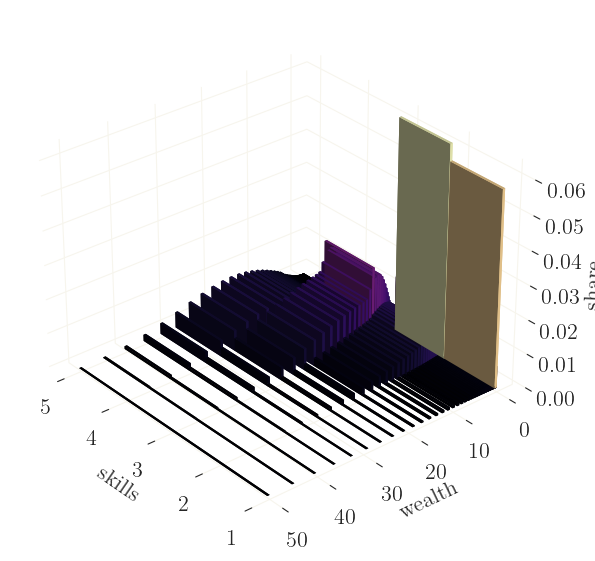

In [11]:
from grgrlib import grbar3d # a nice backend to 3D-plots with matplotlib

ax, _ = grbar3d(dist, xedges=jnp.arange(1,5), yedges=grid, figsize=(9,7), depth=.5) # create 3D plot
# set axis labels
ax.set_xlabel('skills')
ax.set_ylabel('wealth')
ax.set_zlabel('share')
# rotate
ax.view_init(azim=140)

Nice. As expected, agents with higher income hold more assets, and vice versa.

Let's continue with calculating some impulse response functions. We'll have a look at a shock to the households' discount factor $\beta$. 

Find the *nonlinear* IRFs (I'll show below how to find the linear IRFs):

In [12]:
# define the shock as (shock_name, value)
shock = ('e_beta', 0.005)
# simulate
xst, flags = hank1.find_path(shock)

(get_derivatives:) Derivatives calculation done (6.270s).
(get_jacobian:) Jacobian accumulation and decomposition done (1.211s).
    Iteration  1 | fev.   1 | max. error 7.02e-02 | dampening 1.000
    Iteration  2 | fev.  15 | max. error 1.68e-02 | dampening 1.000
    Iteration  3 | fev.  26 | max. error 1.11e-03 | dampening 1.000
    Iteration  4 | fev.  29 | max. error 9.26e-06 | dampening 1.000
    Iteration  5 | fev.  34 | max. error 5.85e-07 | dampening 1.000
    Iteration  6 | fev.  40 | max. error 3.50e-08 | dampening 1.000
    Iteration  7 | fev.  46 | max. error 1.77e-09 | dampening 1.000 | lapsed 11.0975s
(find_path:) Stacking done (18.775s). The solution converged.


Alternatively, take the steady state as the initial value, and alter the initial value of $\beta$ directly. Also that a second run will be much faster because all objects are already compiled:

In [13]:
# this is a dict containing the steady state values
x0 = hank1['stst'].copy()
# setting a large shock on the discount factor
x0['beta'] *= 1.009

# simulate again with the different initial state:
xst, flags = hank1.find_path(init_state=x0.values())

    Iteration  1 | fev.   1 | max. error 1.13e-01 | dampening 1.000
    Iteration  2 | fev.  32 | max. error 4.76e-02 | dampening 1.000
    Iteration  3 | fev.  63 | max. error 1.09e-01 | dampening 0.619
    Iteration  4 | fev.  94 | max. error 3.84e-03 | dampening 1.000
    Iteration  5 | fev. 108 | max. error 2.20e-04 | dampening 1.000
    Iteration  6 | fev. 132 | max. error 9.08e-06 | dampening 1.000
    Iteration  7 | fev. 157 | max. error 8.16e-07 | dampening 1.000
    Iteration  8 | fev. 182 | max. error 7.31e-08 | dampening 1.000
    Iteration  9 | fev. 207 | max. error 6.54e-09 | dampening 1.000 | lapsed 6.0853s
(find_path:) Stacking done (6.172s). The solution converged.


That went smoothly. Again, you will get (hopefully) meaningful and (hopefully) infomative final messages. Note that the second run was **much** faster than the first one. This is because the steady state sequence space Jacobian was already calculated and all functions were already compiled. 

Let's plot only a few of the variables for space restrictions: output $y_t$ (`Y`), inflation $\pi_t$ (`pi`), the nominal interst rate $R_t$ (`Rn`), and the percentage share of wealth held by the top-10% richest, `Top10A`.

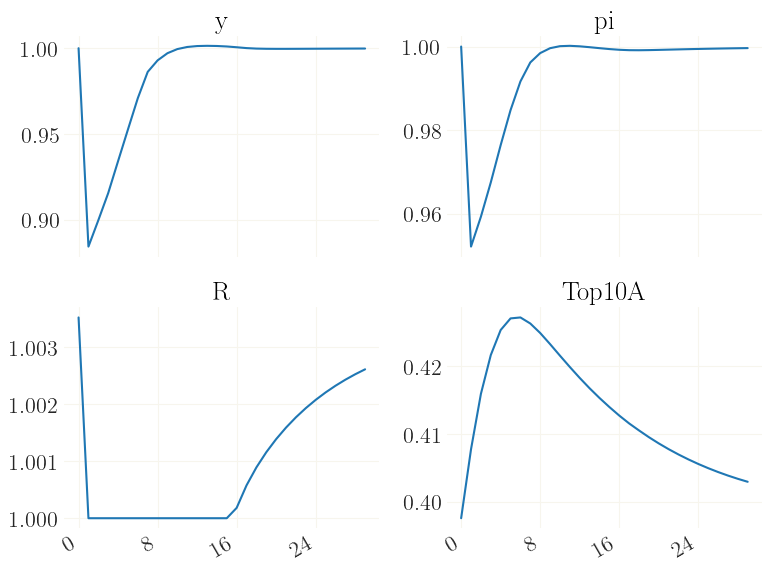

In [14]:
# this is how *all* aggregate variables could be plotted:
#grplot(xst[:30], labels=hank1['variables']) 

variables = 'y', 'pi', 'R', 'Top10A'
inds = [hank1['variables'].index(v) for v in variables] # get indices of variables

_ = grplot(xst[:30, inds], labels=variables)

See how the effective lower bound is binding for quite a while, and how the endogenous distribution adjusts accordingly. 

In case you want to study the distributional dynamics in detail, you can also back out the exact *nonlinear sequences* of the disaggregated variables and their distribution. That is, their complete history given the trajectory ``xst`` of aggregated variables.

In [15]:
# note that the sequence of aggregated variables is the input
het_vars = hank1.get_distributions(xst)

The function will return a dictionary with the disaggregated variables (``outputs`` of the decision stage) and the distribution as key:

In [16]:
print(het_vars.keys())

dict_keys(['a', 'c', 'dist'])


Each of the objects has shape ``*distribution shape, number_of_periods``:

In [17]:
print(het_vars['a'].shape)

(4, 50, 199)


For example, we can use this to plot the distribution of wealth over time:

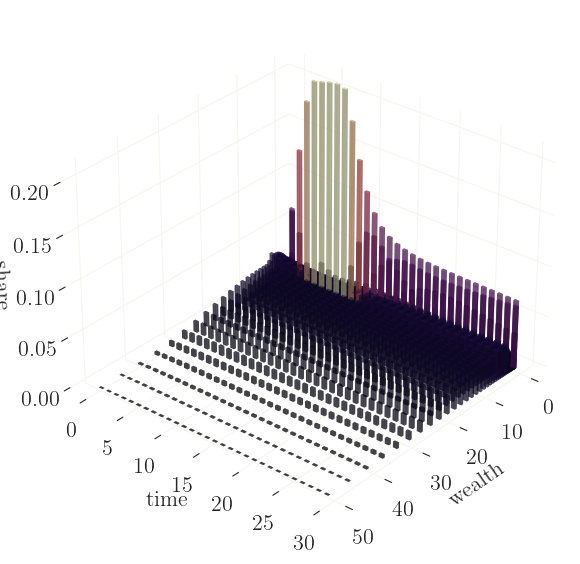

In [18]:
dist = het_vars['dist']
a_grid = hank1['context']['a_grid']
# plot
ax, _ = grbar3d(dist[...,:30].sum(0), xedges=a_grid, yedges=jnp.arange(30), figsize=(9,7), depth=.5, width=.5, alpha=.5)
# set axis labels
ax.set_xlabel('wealth')
ax.set_ylabel('time')
ax.set_zlabel('share')
# rotate
ax.view_init(azim=40) 

The graph shows that the discount factor shock (and the ZLB) mainly affects the wealth of the housholds which hold no or very few liquid assets, causing them to hold more assets.